In [1]:
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")

In [2]:
program_id = "qaoa"
qaoa_program = provider.runtime.program(program_id)

In [3]:
print(f"Program name: {qaoa_program.name}, Program id: {qaoa_program.program_id}")
print(qaoa_program.parameters())

Program name: qaoa, Program id: qaoa
ParameterNamespace (Values):
| Name       | Value        | Type         | Required |     Description |
-------------------------------------------------------------------------
| reps       | None         | integer     | False    | The number of QAOA repetitions, i.e. the QAOA depth typically labeled p. This value defaults to 1. This is an integer. |
| operator   | None         | object      | True     | The cost Hamiltonian, consisting of Pauli I and Z operators, whose smallest eigenvalue we're trying to find. The type must be a PauliSumOp. |
| optimizer  | None         | object      | False    | The classical optimizer used to update the parameters in each iteration. Per default, SPSA with automatic calibration of the learning rate is used. The type must be a qiskit.algorithms.optimizers.Optimizer. |
| initial_po | None         | ['array', 's| False    | Initial parameters of the ansatz. Can be an array or the string ``'random'`` to choose random 

In [4]:
import numpy as np

from qiskit.tools import job_monitor
from qiskit.opflow import PauliSumOp, Z, I
from qiskit.algorithms.optimizers import SPSA

# Define the cost operator to run.
op = (
    (Z ^ Z ^ I ^ I ^ I)
    - (I ^ I ^ Z ^ Z ^ I)
    + (I ^ I ^ Z ^ I ^ Z)
    - (Z ^ I ^ Z ^ I ^ I)
    - (I ^ Z ^ Z ^ I ^ I)
    + (I ^ Z ^ I ^ Z ^ I)
    + (I ^ I ^ I ^ Z ^ Z)
)

# SPSA helps deal with noisy environments.
optimizer = SPSA(maxiter=100)

# We will run a depth two QAOA.
reps = 2

# The initial point for the optimization, chosen at random.
initial_point = np.random.random(2 * reps)

# The backend that will run the programm.
options = {"backend_name": "ibmq_qasm_simulator"}

# The inputs of the program as described above.
runtime_inputs = {
    "operator": op,
    "reps": reps,
    "optimizer": optimizer,
    "initial_point": initial_point,
    "shots": 2**13,
    # Set to True when running on real backends to reduce circuit
    # depth by leveraging swap strategies. If False the
    # given optimization_level (default is 1) will be used.
    "use_swap_strategies": False,
    # Set to True when optimizing sparse problems.
    "use_initial_mapping": False,
    # Set to true when using echoed-cross-resonance hardware.
    "use_pulse_efficient": False,
}

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
job = provider.runtime.run(
    program_id=program_id,
    options=options,
    inputs=runtime_inputs,
)

In [6]:
print(f"Job id: {job.job_id()}")
print(f"Job status: {job.status()}")

Job id: cc2ads31uoq3f11lai2g
Job status: JobStatus.RUNNING


In [7]:
result = job.result()

In [8]:
from collections import defaultdict


def op_adj_mat(op: PauliSumOp) -> np.array:
    """Extract the adjacency matrix from the op."""
    adj_mat = np.zeros((op.num_qubits, op.num_qubits))
    for pauli, coeff in op.primitive.to_list():
        idx = tuple([i for i, c in enumerate(pauli[::-1]) if c == "Z"])  # index of Z
        adj_mat[idx[0], idx[1]], adj_mat[idx[1], idx[0]] = np.real(coeff), np.real(coeff)

    return adj_mat


def get_cost(bit_str: str, adj_mat: np.array) -> float:
    """Return the cut value of the bit string."""
    n, x = len(bit_str), [int(bit) for bit in bit_str[::-1]]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost += adj_mat[i, j] * x[i] * (1 - x[j])

    return cost


def get_cut_distribution(result) -> dict:
    """Extract the cut distribution from the result.

    Returns:
        A dict of cut value: probability.
    """

    adj_mat = op_adj_mat(PauliSumOp.from_list(result["inputs"]["operator"]))

    state_results = []
    for bit_str, amp in result["eigenstate"].items():
        state_results.append((bit_str, get_cost(bit_str, adj_mat), amp**2 * 100))

    vals = defaultdict(int)

    for res in state_results:
        vals[res[1]] += res[2]

    return dict(vals)

Text(0, 0.5, 'Probability')

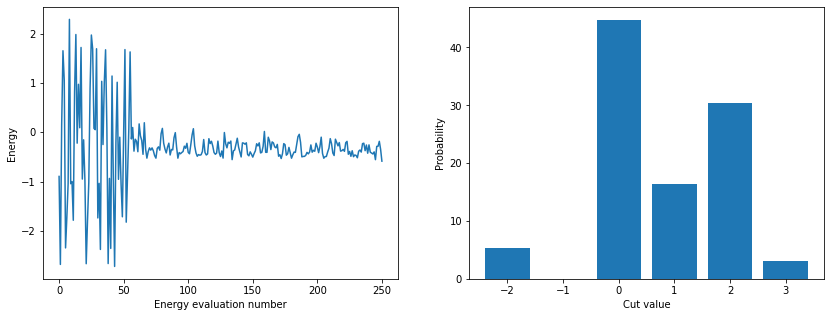

In [9]:
import matplotlib.pyplot as plt

cut_vals = get_cut_distribution(result)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(result["optimizer_history"]["energy"])
axs[1].bar(list(cut_vals.keys()), list(cut_vals.values()))
axs[0].set_xlabel("Energy evaluation number")
axs[0].set_ylabel("Energy")
axs[1].set_xlabel("Cut value")
axs[1].set_ylabel("Probability")

Optimization

In [10]:
from qiskit_optimization.runtime import QAOAClient
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram

In [11]:
qubo = QuadraticProgram()
qubo.binary_var("x")
qubo.binary_var("y")
qubo.binary_var("z")
qubo.minimize(linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2})
print(qubo.prettyprint())

Problem name: 

Minimize
  x*y - x*z + 2*y*z + x - 2*y + 3*z

Subject to
  No constraints

  Binary variables (3)
    x y z



In [12]:
qaoa_mes = QAOAClient(
    provider=provider, backend=provider.get_backend("ibmq_qasm_simulator"), reps=2, alpha=0.75
)

qaoa = MinimumEigenOptimizer(qaoa_mes)

In [13]:
result = qaoa.solve(qubo)
print(result.prettyprint())

objective function value: -2.0
variable values: x=0.0, y=1.0, z=0.0
status: SUCCESS


Appendix

In [14]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library.standard_gates.equivalence_library import (
    StandardEquivalenceLibrary as std_eqlib,
)
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnrollCustomDefinitions,
    BasisTranslator,
    Optimize1qGatesDecomposition,
)
from qiskit.transpiler.passes.calibration.builders import RZXCalibrationBuilderNoEcho
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import (
    EchoRZXWeylDecomposition,
)

from qiskit.test.mock import FakeBelem

/tmp/ipykernel_60/1168752190.py:17: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeBelem


In [15]:
backend = FakeBelem()

In [16]:
inst_map = backend.defaults().instruction_schedule_map
channel_map = backend.configuration().qubit_channel_mapping
rzx_basis = ["rzx", "rz", "x", "sx"]

pulse_efficient = PassManager(
    [
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=["rz", "sx", "x", "rxx"]),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(
            instruction_schedule_map=inst_map, qubit_channel_mapping=channel_map
        ),
        # Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis),
    ]
)

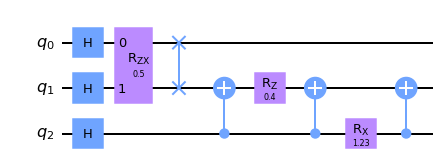

In [17]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(3)
circ.h([0, 1, 2])
circ.rzx(0.5, 0, 1)
circ.swap(0, 1)
circ.cx(2, 1)
circ.rz(0.4, 1)
circ.cx(2, 1)
circ.rx(1.23, 2)
circ.cx(2, 1)
circ.draw("mpl")

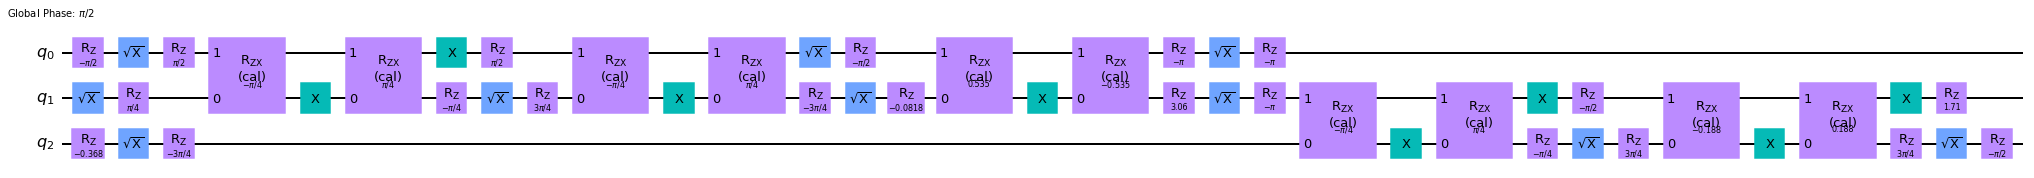

In [18]:
pulse_efficient.run(circ).draw("mpl", fold=False)

In [19]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright